<a href="https://colab.research.google.com/github/KFurudate/RStanBook/blob/main/Chapter_10_1_4_multinomial_logistic_regression_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 多項ロジスティック回帰

目的：どのような年齢・性別・年収の人がどのカテゴリーを選びやすかを知ること

詳細については、書籍を参照。

fkubotaさん（@the_phi_is_cast）に貴重なアドバイスいただきました。ありがとうございました！
https://twitter.com/FurudateK/status/1339713135033393152

参考にさせていただきました。
*  https://gaiasky.hatenablog.com/entry/2018/09/11/214855
*  https://gist.github.com/n-ken


In [1]:
DAY="20201217"

In [2]:
from google.colab import drive
drive.mount('/content/drive')
!ls drive/MyDrive/RStanBook_アヒル本/

Mounted at /content/drive
'Chapter 10_1_4_multinomial_logistic_regression.ipynb'
'Chapter 10_1_4_multinomial_logistic_regression.v2.ipynb'
'Chapter 10_1_4_multinomial_logistic_regression.v3.ipynb'
 input
 output
 RStanBook-master
'StanとRでベイズ統計モデリング Wonderful R 2 松浦 健太郎 282p_B07M8LWLS1.pdf'


In [3]:
!chmod -R 777 drive/MyDrive/RStanBook_アヒル本/input
!ls -all drive/MyDrive/RStanBook_アヒル本/input

total 147
-rwx------ 1 root root   921 May 10  2020 d1.csv
-rwx------ 1 root root  1116 May 10  2020 data-2Dmesh-design.txt
-rwx------ 1 root root  1908 May 10  2020 data-2Dmesh.txt
-rwx------ 1 root root   979 May 10  2020 data3a.csv
-rwx------ 1 root root  1145 May 10  2020 data4a.csv
-rwx------ 1 root root   816 May 10  2020 data-50m.txt
-rwx------ 1 root root   497 May 10  2020 data7a.csv
-rwx------ 1 root root  1680 May 10  2020 data-aircon.txt
-rwx------ 1 root root   593 May 10  2020 data-attendance-1.txt
-rwx------ 1 root root   751 May 10  2020 data-attendance-2.txt
-rwx------ 1 root root 30253 May 10  2020 data-attendance-3.txt
-rwx------ 1 root root   447 May 10  2020 data-attendance-4-1.txt
-rwx------ 1 root root 21347 May 10  2020 data-attendance-4-2.txt
-rwx------ 1 root root  1114 May 10  2020 data-attendance-5.txt
-rwx------ 1 root root  3317 May 10  2020 data-category.txt
-rwx------ 1 root root  3614 May 10  2020 data-changepoint.txt
-rwx------ 1 root root   202 May 10

In [4]:
!pip install pymc3==3.10.0

     |████████████████████████████████| 1.9MB 12.7MB/s 
     |████████████████████████████████| 1.5MB 50.6MB/s 
     |████████████████████████████████| 2.8MB 51.1MB/s 
     |████████████████████████████████| 4.3MB 47.0MB/s 
     |████████████████████████████████| 737kB 51.5MB/s 
     |████████████████████████████████| 102kB 8.8MB/s 
     |████████████████████████████████| 296kB 34.8MB/s 
  Created wheel for theano-pymc: filename=Theano_PyMC-1.0.11-cp36-none-any.whl size=2572023 sha256=a3541305b3ecdd2af1072a40ec692df6440b23a381c4470141df86385b021dfa
  Stored in directory: /root/.cache/pip/wheels/26/b2/77/4ee2bb9b1c1de7de771254a5e379d898273d8114237b0df686
  Created wheel for contextvars: filename=contextvars-2.4-cp36-none-any.whl size=7667 sha256=2db044ef2307f03bc615af44dc74a27b6fd6ae00a75615b661497148c22b6b61
  Stored in directory: /root/.cache/pip/wheels/a5/7d/68/1ebae2668bda2228686e3c1cf16f2c2384cea6e9334ad5f6de
Successfully built theano-pymc contextvars
  Found existing installation:

In [5]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

import pymc3 as pm
from theano import shared
from theano import tensor as tt

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

import sys
print("Python version")
print(sys.version)

Python version
3.6.9 (default, Oct  8 2020, 12:12:24) 
[GCC 8.4.0]


In [6]:
PATH="drive/MyDrive/RStanBook_アヒル本/"

In [7]:
!mkdir -p drive/MyDrive/RStanBook_アヒル本/output/$DAY

In [8]:
outdir = f"drive/MyDrive/Phylogeny/output/{DAY}/"

In [9]:
INPUT1 = "data-category.txt"

In [10]:
df = pd.read_csv(PATH + f"input/{INPUT1}")
df

,Age,Sex,Income,Y
0,18,1,472,2
1,18,0,468,5
2,18,1,451,6
3,18,1,441,6
4,18,1,499,6
...,...,...,...,...
295,55,1,432,1
296,55,1,531,1
297,55,0,369,4
298,55,1,690,2


In [11]:
X = shared(df[['Age', 'Sex', 'Income']].values)
y = shared(df['Y'].values - 1)

# カテゴリ数 
k = len(df['Y'].unique())

In [12]:
with pm.Model() as model:
    # prior
    # カテゴリ１を選ぶ強さを0に固定する→残りのカテゴリを選ぶ強さはカテゴリ1との比較から決まる
    # パラメータ数は、後で0を加えるため、カテゴリ数-1になる。
    intercept = pm.Normal("intercept", mu=0, sd=100, shape=(k-1,))
    slope = pm.Normal("slope", mu=0, sd=100, shape=(3, k-1))

    # 係数を1つ0に固定する
    concat_intercept = tt.concatenate([tt.zeros(1), intercept])
    concat_slope = tt.concatenate([tt.zeros((3, 1)), slope], axis=1)

    mu = concat_intercept + X.dot(concat_slope)
    p = pm.Deterministic("p", tt.nnet.softmax(mu))

    # likelihood
    obs = pm.Categorical("obs", p=p, observed=y)

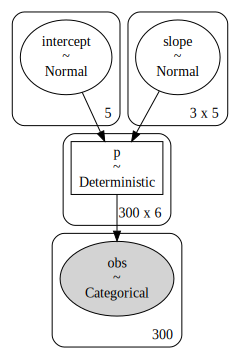

In [13]:
ret = pm.model_to_graphviz(model)
ret.render(filename=outdir + f'{DAY}_model', format='png')
ret

In [14]:
with model:
    start = pm.find_MAP(method='Powell')
    step = pm.NUTS()
    trace = pm.sample(1000, step=step)

Sequential sampling (2 chains in 1 job)
NUTS: [slope, intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 75 seconds.


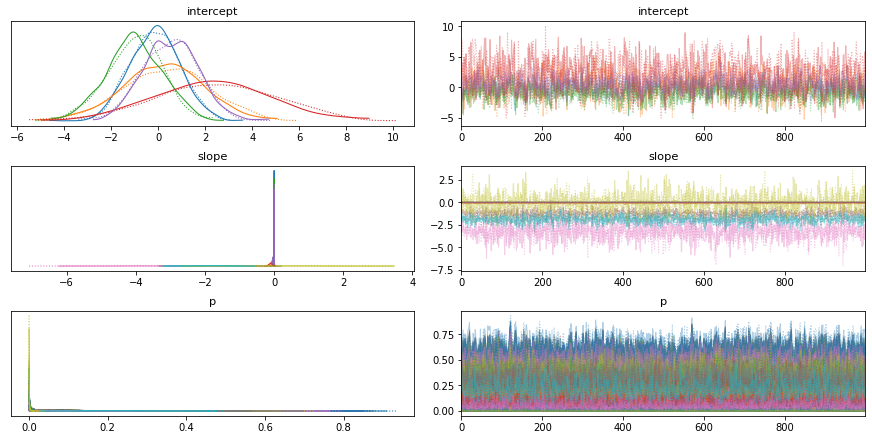

In [15]:
_ = pm.traceplot(trace)

In [17]:
pm.summary(trace).T

,intercept[0],intercept[1],intercept[2],intercept[3],intercept[4],"slope[0,0]","slope[0,1]","slope[0,2]","slope[0,3]","slope[0,4]","slope[1,0]","slope[1,1]","slope[1,2]","slope[1,3]","slope[1,4]","slope[2,0]","slope[2,1]","slope[2,2]","slope[2,3]","slope[2,4]","p[0,0]","p[0,1]","p[0,2]","p[0,3]","p[0,4]","p[0,5]","p[1,0]","p[1,1]","p[1,2]","p[1,3]","p[1,4]","p[1,5]","p[2,0]","p[2,1]","p[2,2]","p[2,3]","p[2,4]","p[2,5]","p[3,0]","p[3,1]",...,"p[293,2]","p[293,3]","p[293,4]","p[293,5]","p[294,0]","p[294,1]","p[294,2]","p[294,3]","p[294,4]","p[294,5]","p[295,0]","p[295,1]","p[295,2]","p[295,3]","p[295,4]","p[295,5]","p[296,0]","p[296,1]","p[296,2]","p[296,3]","p[296,4]","p[296,5]","p[297,0]","p[297,1]","p[297,2]","p[297,3]","p[297,4]","p[297,5]","p[298,0]","p[298,1]","p[298,2]","p[298,3]","p[298,4]","p[298,5]","p[299,0]","p[299,1]","p[299,2]","p[299,3]","p[299,4]","p[299,5]"
mean,-0.149,0.269,-1.014,2.364,0.523,-0.015,-0.049,-0.022,-0.098,-0.032,-1.209,-3.320,-1.848,0.023,-1.949,0.003,0.002,0.005,-0.003,0.003,0.320,0.241,0.024,0.116,0.142,0.158,0.092,0.223,0.141,0.198,0.046,0.300,0.327,0.233,0.023,0.108,0.156,0.153,0.331,0.228,...,0.060,0.227,0.004,0.223,0.151,0.303,0.056,0.268,0.002,0.220,0.588,0.228,0.007,0.080,0.014,0.084,0.517,0.263,0.008,0.110,0.008,0.094,0.268,0.280,0.065,0.165,0.009,0.213,0.393,0.311,0.008,0.174,0.004,0.109,0.088,0.291,0.052,0.361,0.001,0.207
sd,1.060,1.778,1.185,2.528,1.170,0.015,0.028,0.017,0.046,0.018,0.357,0.859,0.402,0.939,0.399,0.002,0.003,0.002,0.004,0.002,0.072,0.059,0.020,0.039,0.083,0.049,0.031,0.053,0.062,0.056,0.039,0.070,0.076,0.060,0.020,0.038,0.091,0.050,0.078,0.061,...,0.035,0.058,0.006,0.059,0.044,0.064,0.034,0.064,0.004,0.058,0.080,0.061,0.008,0.031,0.017,0.034,0.072,0.057,0.007,0.035,0.010,0.033,0.082,0.079,0.049,0.061,0.015,0.075,0.081,0.070,0.009,0.056,0.007,0.041,0.039,0.083,0.042,0.098,0.003,0.074
hdi_3%,-2.004,-3.064,-3.476,-2.556,-1.681,-0.046,-0.102,-0.053,-0.189,-0.065,-1.853,-4.895,-2.536,-1.535,-2.712,-0.000,-0.003,0.001,-0.011,-0.001,0.178,0.140,0.001,0.047,0.012,0.071,0.039,0.128,0.035,0.096,0.002,0.176,0.177,0.120,0.001,0.043,0.020,0.063,0.175,0.115,...,0.008,0.128,0.000,0.123,0.075,0.185,0.006,0.153,0.000,0.120,0.441,0.124,0.000,0.029,0.000,0.024,0.391,0.155,0.000,0.047,0.000,0.043,0.126,0.139,0.003,0.061,0.000,0.083,0.234,0.189,0.000,0.073,0.000,0.043,0.026,0.136,0.003,0.172,0.000,0.075
hdi_97%,1.893,3.711,1.050,6.887,2.647,0.010,0.004,0.011,-0.013,0.001,-0.524,-1.708,-1.018,1.956,-1.209,0.006,0.008,0.008,0.005,0.006,0.440,0.358,0.059,0.186,0.285,0.249,0.150,0.324,0.253,0.299,0.114,0.428,0.454,0.341,0.059,0.178,0.319,0.243,0.461,0.337,...,0.124,0.336,0.012,0.339,0.237,0.417,0.112,0.385,0.008,0.336,0.739,0.345,0.021,0.135,0.042,0.143,0.658,0.366,0.021,0.171,0.025,0.161,0.423,0.428,0.150,0.272,0.032,0.350,0.531,0.445,0.025,0.275,0.014,0.186,0.157,0.442,0.127,0.530,0.004,0.339
mcse_mean,0.043,0.064,0.044,0.087,0.044,0.000,0.001,0.001,0.001,0.001,0.010,0.021,0.011,0.024,0.012,0.000,0.000,0.000,0.000,0.000,0.003,0.001,0.000,0.001,0.002,0.001,0.001,0.001,0.002,0.001,0.001,0.002,0.003,0.002,0.000,0.001,0.002,0.001,0.003,0.002,...,0.001,0.001,0.000,0.001,0.001,0.001,0.001,0.001,0.000,0.001,0.002,0.001,0.000,0.001,0.000,0.001,0.002,0.001,0.000,0.001,0.000,0.001,0.003,0.002,0.001,0.001,0.000,0.002,0.003,0.002,0.000,0.001,0.000,0.001,0.002,0.002,0.001,0.002,0.000,0.002
mcse_sd,0.031,0.045,0.031,0.062,0.031,0.000,0.001,0.000,0.001,0.000,0.007,0.016,0.008,0.024,0.008,0.000,0.000,0.000,0.000,0.000,0.002,0.001,0.000,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.002,0.001,0.000,0.001,0.002,0.001,0.002,0.001,...,0.001,0.001,0.000,0.001,0.001,0.001,0.001,0.001,0.000,0.001,0.002,0.001,0.000,0.001,0.000,0.001,0.002,0.001,0.000,0.001,0.000,0.001,0.002,0.001,0.001,0.001,0.000,0.001,0.002,0.001,0.000,0.001,0.000,0.001,0.001,0.001,0.001,0.001,0.000,0.001
ess_mean,594.000,772.000,715.000,838.000,704.000,1064.000,1144.000,1044.000,1668.000,1058.000,1205.000,1740.000,1301.000,1489.000,1181